# Introduction

This notebook uses the Temporal Fusion Transformer (TFT) model implemented in PyTorch forecasting. It follows the tutorial notebook [here](https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html). It loads the merged feature file created by the Data preparation notebook/script, then splits that into train/validation/test split. Then uses the pytorch trainer to fit the model. And finally plots the predictions and interpretations. 

# Imports

In [1]:
import os, gc
import torch

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_columns', None)

# Initial setup

## GPU

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


## Google colab

Set `running_on_colab` to true if you are running on google colab. They don't have these libraries installed by default. Uncomment the codes too if needed. They might be commented out since in .py script inline commands show errors.

Use only the pip install part if you are on rivanna, using a default tensorflow kernel.

In [3]:
running_on_colab = False

# if running_on_colab:
#     !pip install pytorch_lightning
#     !pip install pytorch_forecasting

#     from google.colab import drive

#     drive.mount('/content/drive')
#     %cd /content/drive/My Drive/TFT-pytorch/notebook

## Pytorch lightning and forecasting

In [4]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer
from pytorch_forecasting.metrics import RMSE, MultiLoss

# Load input

In [5]:
from dataclasses import dataclass

@dataclass
class args:
    result_folder = '../results/total_target_cleaned_scaled'
    figPath = os.path.join(result_folder, 'figures')
    checkpoint_folder = os.path.join(result_folder, 'checkpoints')
    input_filePath = '../2022_May_target_cleaned/Total.csv'

    # pass your intented configuration here
    # input features are always normalized. But keeping the targets features unscaled improves results
    # if you want to change some config, but not to create a new config file, just change the value
    # of the corresponding parameter in the config section
    configPath = '../configurations/total_target_cleaned_scaled.json'
    # configPath = '../config_2022_Aug.json'

    # Path/URL of the checkpoint from which training is resumed
    ckpt_model_path = None # os.path.join(checkpoint_folder, 'latest-epoch=7.ckpt')
    
    # set this to false when submitting batch script, otherwise it prints a lot of lines
    show_progress_bar = True

    # interpret_output has high memory requirement
    # results in out-of-memery for Total.csv and a model of hidden size 64, even with 64GB memory
    interpret_train = 'Total.csv' not in input_filePath

In [6]:
total_data = pd.read_csv(args.input_filePath)
print(total_data.shape)
total_data.head()

(80900, 15)


,FIPS,AgeDist,HealthDisp,Name,Date,DiseaseSpread,Transmission,VaccinationFull,SocialDist,Cases,Deaths,TimeFromStart,LinearSpace,SinWeekly,CosWeekly
0,4013,0.4991,0.3334,"Arizona, Maricopa",2020-02-29,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0328,-0.9749,-0.2225
1,4013,0.4991,0.3334,"Arizona, Maricopa",2020-03-01,0.0,0.0,0.0,1.0,0.0,0.0,1,0.0328,-0.7818,0.6235
2,4013,0.4991,0.3334,"Arizona, Maricopa",2020-03-02,0.0,0.0,0.0,1.0,0.0,0.0,2,0.0328,0.0000,1.0000
3,4013,0.4991,0.3334,"Arizona, Maricopa",2020-03-03,0.0,0.0,0.0,1.0,0.0,0.0,3,0.0328,0.7818,0.6235
4,4013,0.4991,0.3334,"Arizona, Maricopa",2020-03-04,0.0,0.0,0.0,1.0,0.0,0.0,4,0.0328,0.9749,-0.2225


# Config

In [7]:
import json
import sys
sys.path.append( '..' )
from Class.Parameters import Parameters
from script.utils import *

with open(args.configPath, 'r') as input_file:
  config = json.load(input_file)

parameters = Parameters(config, **config)

In [8]:
targets = parameters.data.targets
time_idx = parameters.data.time_idx
tft_params = parameters.model_parameters

# google colab doesn't utilize GPU properly for pytorch
# so increasing batch size forces more utilization
# not needed on rivanna or your local machine

if running_on_colab: 
    tft_params.batch_size *= 4

max_prediction_length = tft_params.target_sequence_length
max_encoder_length = tft_params.input_sequence_length
parameters.data.time_varying_known_features.append('LinearSpace')

# Seed

In [9]:
import random

def seed_torch(seed=7):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    pl.seed_everything(seed)

seed_torch(tft_params.seed)

Global seed set to 7


# Processing

In [10]:
total_data['Date'] = pd.to_datetime(total_data['Date'].values) 
total_data['FIPS'] = total_data['FIPS'].astype(str)
print(f"There are {total_data['FIPS'].nunique()} unique counties in the dataset.")

There are 100 unique counties in the dataset.


## Adapt input to encoder length
Input data length needs to be a multiple of encoder length to created batch data loaders.

In [11]:
train_start = parameters.data.split.train_start
total_data = total_data[total_data['Date']>=train_start]
total_data[time_idx] = (total_data["Date"] - train_start).apply(lambda x: x.days)

## Train validation test split and scaling

In [12]:
train_data, validation_data, test_data = train_validation_test_split(
    total_data, parameters
)

Train samples 64000, validation samples 9800, test samples 9700
640 days of training, 85 days of validation data, 84 days of test data.


In [13]:
train_scaled, validation_scaled, test_scaled, target_scaler = scale_data(
    train_data, validation_data, test_data, parameters
)

Scaling static and dynamic input features: ['AgeDist', 'HealthDisp', 'DiseaseSpread', 'Transmission', 'VaccinationFull', 'SocialDist']
Scaling targets ['Cases', 'Deaths']


## Create dataset and dataloaders

In [14]:
def prepare_data(data: pd.DataFrame, pm: Parameters, train=False):

  data_timeseries = TimeSeriesDataSet(
    data,
    time_idx= time_idx,
    target=targets,
    group_ids=pm.data.id, 
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_reals=pm.data.static_features,
    # static_categoricals=['FIPS'],
    time_varying_known_reals = pm.data.time_varying_known_features,
    time_varying_unknown_reals = pm.data.time_varying_unknown_features,
    target_normalizer = MultiNormalizer(
      [GroupNormalizer(groups=pm.data.id) for _ in range(len(targets))]
    )
  )

  if train:
    dataloader = data_timeseries.to_dataloader(train=True, batch_size=tft_params.batch_size)
  else:
    dataloader = data_timeseries.to_dataloader(train=False, batch_size=tft_params.batch_size*8)

  return data_timeseries, dataloader

In [15]:
train_timeseries, train_dataloader = prepare_data(train_scaled, parameters, train=True)
_, validation_dataloader = prepare_data(validation_scaled, parameters)
_, test_dataloader = prepare_data(test_scaled, parameters)

del validation_scaled, test_scaled
gc.collect()

16

# Training

## Trainer and logger

If you have troubles training the model and get an error ```AttributeError: module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'```, consider either uninstalling tensorflow or first execute the following

In [16]:
import tensorflow as tf
# click this and locate the lightning_logs folder path and select that folder. 
# this will load tensorbaord visualization
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [18]:
# notice that the early stopping patience is very high (60) for the old
# TF1 notebook. To reproduce that, replace patience=60
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=tft_params.early_stopping_patience
    , verbose=True, mode="min"
)

# https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.callbacks.ModelCheckpoint.html
best_checkpoint = pl.callbacks.ModelCheckpoint(
    dirpath=args.checkpoint_folder, monitor="val_loss", filename="best-{epoch}"
)
latest_checkpoint = pl.callbacks.ModelCheckpoint(
    dirpath=args.checkpoint_folder, every_n_epochs=1, filename="latest-{epoch}"
)

logger = TensorBoardLogger(args.result_folder)  # logging results to a tensorboard

# https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-class-api
trainer = pl.Trainer(
    max_epochs = tft_params.epochs,
    accelerator = 'auto',
    weights_summary = "top",
    gradient_clip_val = tft_params.clipnorm,
    callbacks = [early_stop_callback, best_checkpoint, latest_checkpoint],
    logger = logger,
    enable_progress_bar = args.show_progress_bar,
    check_val_every_n_epoch = 1,
    # max_time="00:12:00:00",
    # auto_scale_batch_size = False 
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Model

In [19]:
# https://pytorch-forecasting.readthedocs.io/en/stable/api/pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer.html
tft = TemporalFusionTransformer.from_dataset(
    train_timeseries,
    learning_rate= tft_params.learning_rate,
    hidden_size= tft_params.hidden_layer_size,
    attention_head_size=tft_params.attention_head_size,
    dropout=tft_params.dropout_rate,
    loss=MultiLoss([RMSE(reduction='mean') for _ in targets]), # RMSE(reduction='sqrt-mean')
    optimizer='adam',
    log_interval=1,
    # reduce_on_plateau_patience=2
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 230.6k


The training speed is here mostly determined by overhead and choosing a larger `batch_size` or `hidden_size` (i.e. network size) does not slow training linearly making training on large datasets feasible. During training, we can monitor the tensorboard which can be spun up with `tensorboard --logdir=lightning_logs`. For example, we can monitor examples predictions on the training and validation set.

In [20]:
from datetime import datetime

gc.collect()

start = datetime.now()
print(f'\n----Training started at {start}----\n')

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=validation_dataloader,
    ckpt_path=args.ckpt_model_path
)
end = datetime.now()
print(f'\n----Training ended at {end}, elapsed time {end-start}')
print(f'Best model by validation loss saved at {trainer.checkpoint_callback.best_model_path}')


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MultiLoss                       | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 2.1 K 
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.6 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 14.3 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.5 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 16.8 K
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 16.8


----Training started at 2022-08-13 16:42:25.375843----



Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.009



----Training ended at 2022-08-13 16:44:24.520830, elapsed time 0:01:59.144987
Best model by validation loss saved at C:\Softwares\COVID-19-forecast\TFT-pytorch\results\top_100_target_cleaned_scaled\checkpoints\best-epoch=0-v8.ckpt


# Prediction Processor

In [21]:
from Class.PredictionProcessor import PredictionProcessor

processor = PredictionProcessor(
    time_idx, parameters.data.id[0], max_prediction_length, targets, 
    train_start, max_encoder_length
)

# Evaluate - final model

## PlotResults

In [22]:
from Class.Plotter import *

plotter = PlotResults(args.figPath, targets, show=args.show_progress_bar)

## Train results

### Average


---Training results--



Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

prediction list of length 2 torch.Size([61300, 15, 1])
encoder_attention torch.Size([61300, 15, 4, 13])
decoder_attention torch.Size([61300, 15, 4, 15])
static_variables torch.Size([61300, 1, 3])
encoder_variables torch.Size([61300, 13, 1, 8])
decoder_variables torch.Size([61300, 15, 1, 2])
decoder_lengths torch.Size([61300])
encoder_lengths torch.Size([61300])
Target Cases, MAE 168.28, RMSE 346.33, SMAPE 0.75261. NNSE 0.77588.
Target Deaths, MAE 2.7312, RMSE 5.1968, SMAPE 1.0068. NNSE 0.82757.



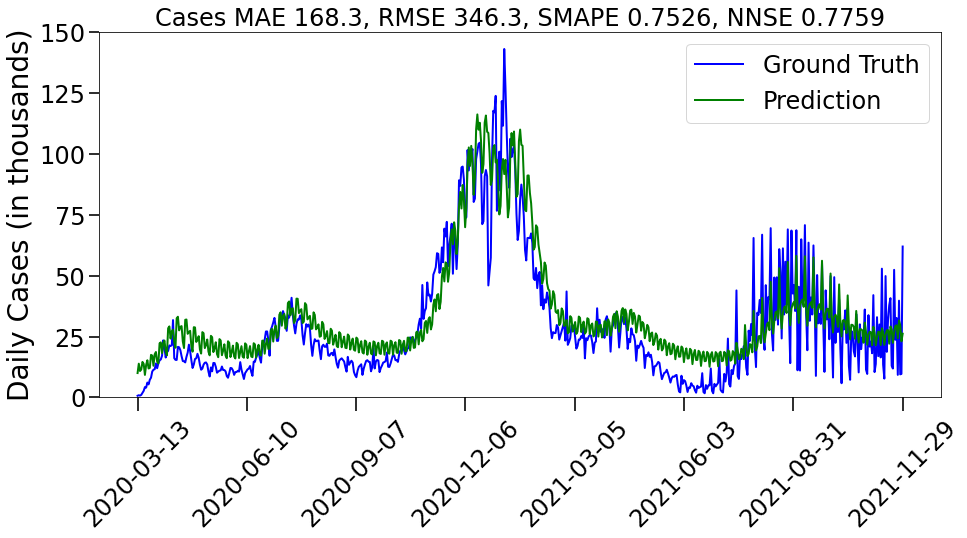

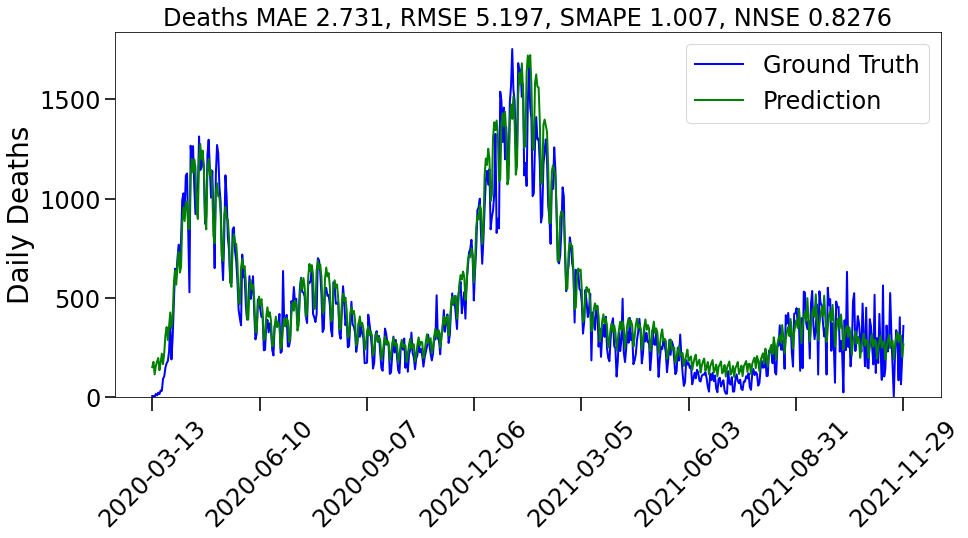

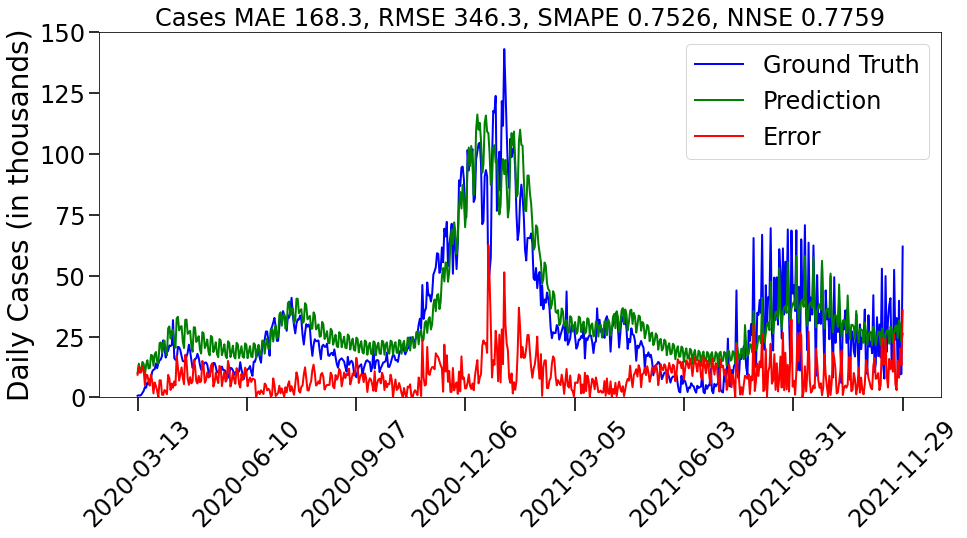

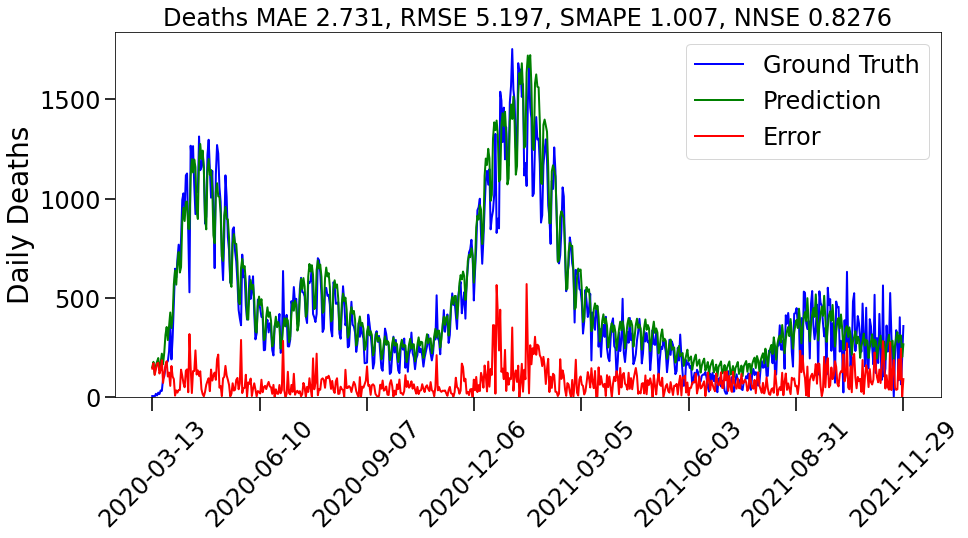

13894

In [23]:
# not a must, but increases inference speed 
_, train_dataloader = prepare_data(train_scaled, parameters) 
print(f'\n---Training results--\n')

# mode="prediction" would return only the prediction. mode="raw" returns additional keys needed for interpretation
train_raw_predictions, train_index = tft.predict(
    train_dataloader, mode="raw", return_index=True, show_progress_bar=args.show_progress_bar
)
for key in train_raw_predictions.keys():
    item = train_raw_predictions[key]
    if type(item)==list: print(key, f'list of length {len(item)}', item[0].shape)
    else: print(key, item.shape)

train_predictions = upscale_prediction(targets, train_raw_predictions['prediction'], target_scaler, max_prediction_length)
train_result_merged = processor.align_result_with_dataset(train_data, train_predictions, train_index)
show_result(train_result_merged, targets)

plotter.summed_plot(train_result_merged, type='Train')
plotter.summed_plot(train_result_merged, type='Train_error', plot_error=True)
gc.collect()

In [ ]:
# predicted_columns = [f'Predicted_{target}' for target in targets]
# temp = train_result_merged.copy()
# if target_scaler is not None:
#     temp.loc[:, predicted_columns] = target_scaler.transform(temp[predicted_columns])
#     temp.loc[:, targets] = target_scaler.transform(temp[targets])
# else:
#     scaler = MinMaxScaler()
#     temp.loc[:, targets] = scaler.fit_transform(temp[targets])
#     temp.loc[:, predicted_columns] = scaler.transform(temp[predicted_columns])
    
# show_result(temp, targets)
# plotter.summed_plot(temp, type='Train_scaled')
# del temp

### By future days

In [ ]:
gc.collect()
for day in range(1, max_prediction_length+1):
    print(f'Day {day}')
    df = processor.align_result_with_dataset(train_data, train_predictions, train_index, target_time_step = day)
    show_result(df, targets)
    plotter.summed_plot(df, type=f'Train_day_{day}')
    break

## Validation results


---Validation results--



Predict:   0%|          | 0/14 [00:00<?, ? batches/s]

Target Cases, MAE 901.48, RMSE 1535.4, SMAPE 1.0674. NNSE 0.57335.
Target Deaths, MAE 5.5002, RMSE 10.895, SMAPE 1.0788. NNSE 0.56343.



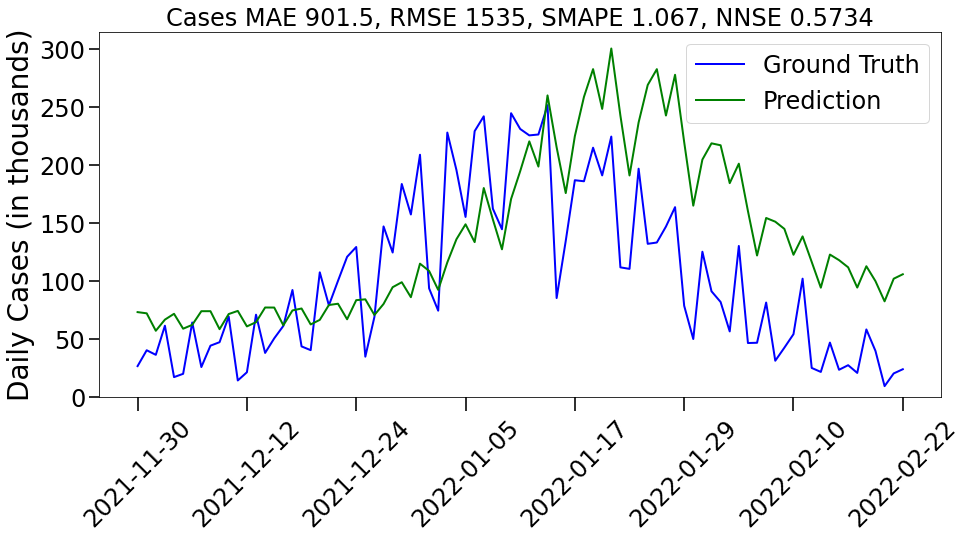

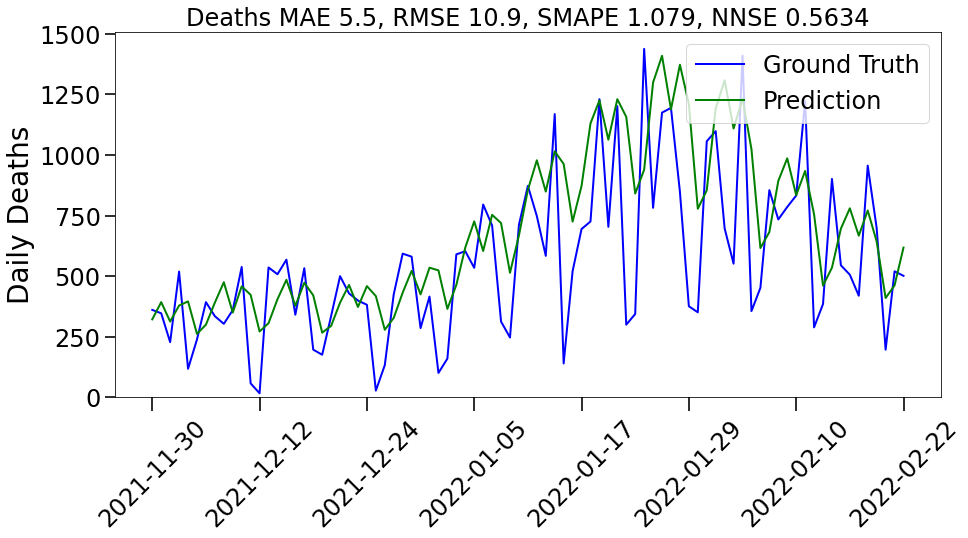

6766

In [26]:
print(f'\n---Validation results--\n')
validation_raw_predictions, validation_index = tft.predict(
    validation_dataloader, mode="raw", return_index=True, show_progress_bar=args.show_progress_bar
)
validation_predictions = upscale_prediction(targets, validation_raw_predictions['prediction'], target_scaler, max_prediction_length)

validation_result_merged = processor.align_result_with_dataset(validation_data, validation_predictions, validation_index)
show_result(validation_result_merged, targets)
plotter.summed_plot(validation_result_merged, type='Validation')
gc.collect()

## Test results

### Average


---Test results--



Predict:   0%|          | 0/14 [00:00<?, ? batches/s]

Target Cases, MAE 228.34, RMSE 479.22, SMAPE 1.215. NNSE 0.5606.
Target Deaths, MAE 2.7317, RMSE 7.7523, SMAPE 1.1756. NNSE 0.54305.



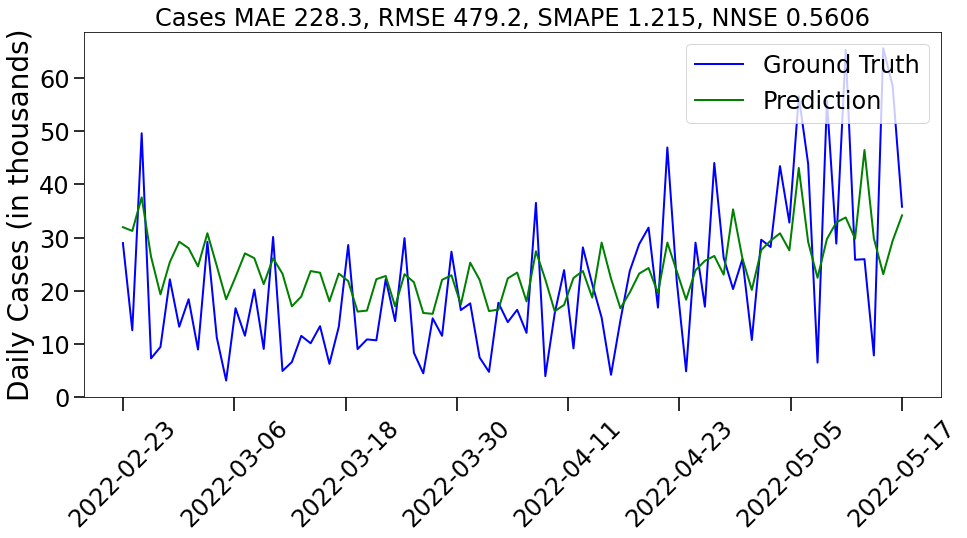

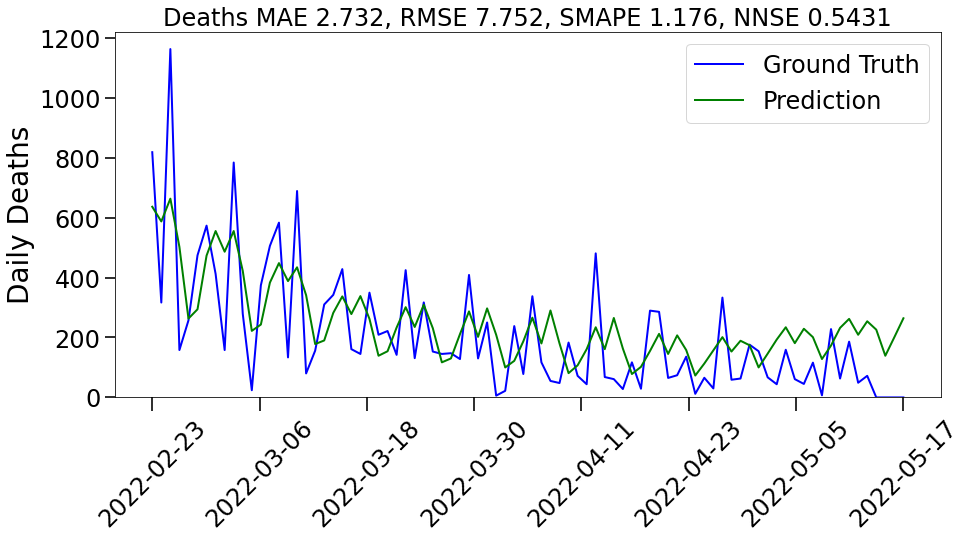

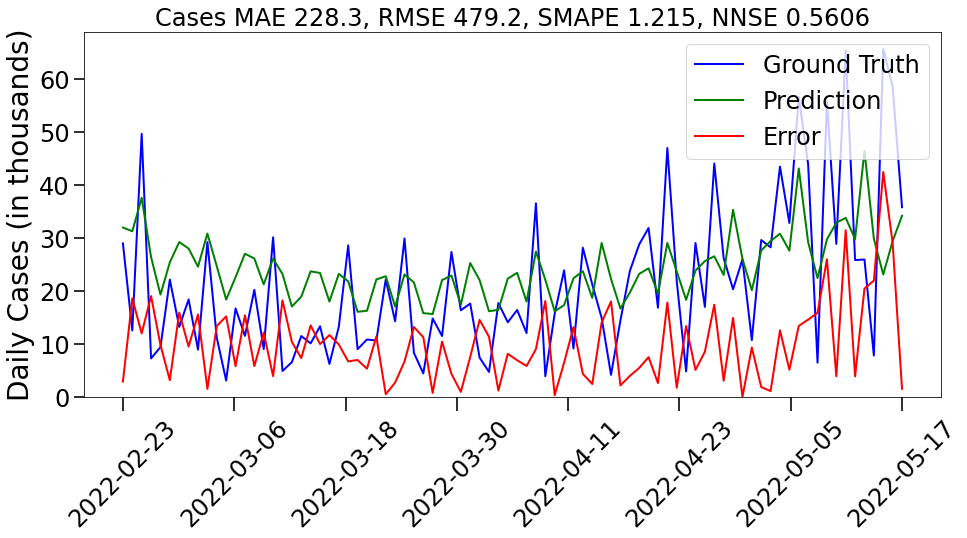

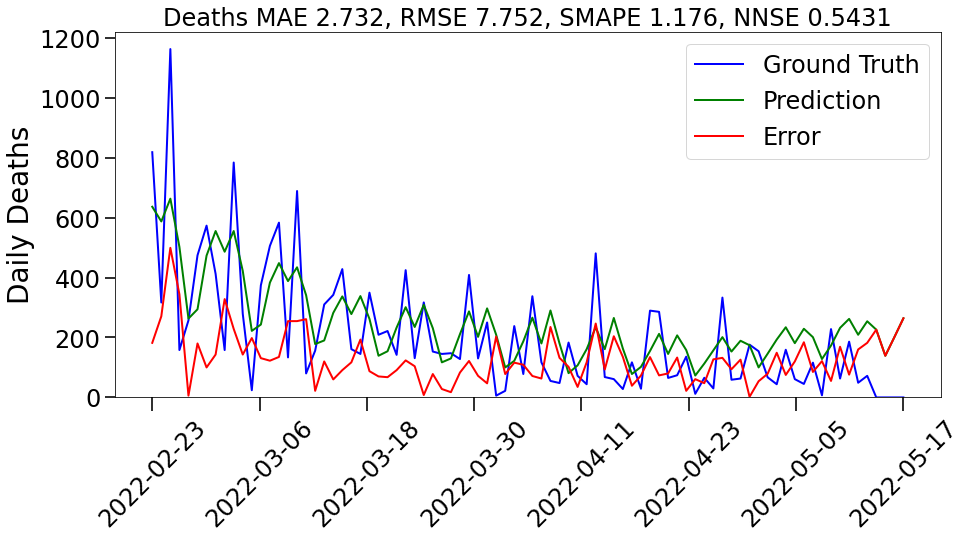

13616

In [27]:
print(f'\n---Test results--\n')
test_raw_predictions, test_index = tft.predict(
    test_dataloader, mode="raw", return_index=True, show_progress_bar=args.show_progress_bar
)
test_predictions = upscale_prediction(targets, test_raw_predictions['prediction'], target_scaler, max_prediction_length)

test_result_merged = processor.align_result_with_dataset(test_data, test_predictions, test_index)
show_result(test_result_merged, targets)
plotter.summed_plot(test_result_merged, 'Test')
plotter.summed_plot(test_result_merged, type='Test_error',  plot_error=True)
gc.collect()

### By future days

In [ ]:
for day in range(1, max_prediction_length+1):
    print(f'Day {day}')
    df = processor.align_result_with_dataset(test_data, test_predictions, test_index, target_time_step = day)
    show_result(df, targets)
    # plotter.summed_plot(df, type=f'Test_day_{day}')
    # break

## Dump results

In [ ]:
train_result_merged['split'] = 'train'
validation_result_merged['split'] = 'validation'
test_result_merged['split'] = 'test'
df = pd.concat([train_result_merged, validation_result_merged, test_result_merged])
df.to_csv(os.path.join(plotter.figPath, 'predictions_case_death.csv'), index=False)

df.head()

In [ ]:
del train_predictions, validation_predictions, test_predictions
gc.collect()

## Evaluation by county

In [ ]:
fips_codes = train_result_merged['FIPS'].unique()
names_df = total_data[['FIPS', 'Name']]

print(f'\n---Per county train results--\n')
count = 5

for index, fips in enumerate(fips_codes):
    if index == count: break

    name = names_df[names_df['FIPS']==fips]['Name'].values[0]
    print(f'County {name}, FIPS {fips}')
    df = train_result_merged[train_result_merged['FIPS']==fips]
    show_result(df, targets)
    print()

In [ ]:
del train_result_merged, validation_result_merged, test_result_merged, df

## Attention weights

In [ ]:
plotWeights = PlotWeights(args.figPath, max_encoder_length, tft, show=args.show_progress_bar)

### Train

In [ ]:
# interpret_output has high memory requirement
# results in out-of-memery for Total.csv and a model of hidden size 64, even with 64GB memory
if args.interpret_train:
    attention_mean, attention = processor.get_mean_attention(
        tft.interpret_output(train_raw_predictions), train_index, return_attention=True
    )
    plotWeights.plot_attention(
        attention_mean, figure_name='Train_daily_attention', 
        limit=0, enable_markers=False, title='Attention with dates'
    )

    attention_weekly = processor.get_attention_by_weekday(attention_mean)
    plotWeights.plot_weekly_attention(attention_weekly, figure_name='Train_weekly_attention')

    attention_mean.round(3).to_csv(os.path.join(plotWeights.figPath, 'attention_mean.csv'), index=False)
    attention.round(3).to_csv(os.path.join(plotWeights.figPath, 'attention.csv'), index=False)

## Variable Importance

### Train

In [ ]:
if args.interpret_train:
    interpretation = tft.interpret_output(train_raw_predictions, reduction="mean")
    for key in interpretation.keys():
        print(key, interpretation[key])
        
    figures = plotWeights.plot_interpretation(interpretation)
    for key in figures.keys():
        figure = figures[key]
        figure.savefig(os.path.join(plotter.figPath, f'Train_{key}.jpg'), dpi=DPI)
    

### Test

In [ ]:
interpretation = tft.interpret_output(test_raw_predictions, reduction="mean")
for key in interpretation.keys():
    print(key, interpretation[key])
    
figures = plotWeights.plot_interpretation(interpretation)
for key in figures.keys():
    figure = figures[key]
    figure.savefig(os.path.join(plotter.figPath, f'Test_{key}.jpg'), dpi=DPI)

## Clear up

In [ ]:
del tft, interpretation
del train_raw_predictions, validation_raw_predictions, test_raw_predictions
gc.collect()

# Evaluate - best model
Best model checkpointed by validation loss.

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(f'Loading best model from {best_model_path}')
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
plotter = PlotResults(f'{args.figPath}_best', targets, show=args.show_progress_bar)

## Train results

### Average

In [ ]:
print(f'\n---Training results--\n')
train_raw_predictions, train_index = best_tft.predict(
    train_dataloader, mode="raw", return_index=True, show_progress_bar=args.show_progress_bar
)
train_predictions = upscale_prediction(targets, train_raw_predictions['prediction'], target_scaler, max_prediction_length)

train_result_merged = processor.align_result_with_dataset(train_data, train_predictions, train_index)
show_result(train_result_merged, targets)
plotter.summed_plot(train_result_merged, type='Train')
plotter.summed_plot(train_result_merged, type='Train_error', plot_error=True)
gc.collect()

### By future days

In [ ]:
# for day in range(1, max_prediction_length+1):
#     print(f'Day {day}')
#     df = processor.align_result_with_dataset(train_data, train_predictions, train_index, target_time_step = day)
#     show_result(df)
    # plotter.summed_plot(df, type=f'Train_day_{day}')

## Validation results

In [ ]:
print(f'\n---Validation results--\n')

validation_raw_predictions, validation_index = best_tft.predict(
    validation_dataloader, mode="raw", return_index=True, show_progress_bar=args.show_progress_bar
)
validation_predictions = upscale_prediction(targets, validation_raw_predictions['prediction'], target_scaler, max_prediction_length)

validation_result_merged = processor.align_result_with_dataset(validation_data, validation_predictions, validation_index)
show_result(validation_result_merged, targets)
plotter.summed_plot(validation_result_merged, type='Validation')
gc.collect()

## Test results

### Average

In [ ]:
print(f'\n---Test results--\n')

test_raw_predictions, test_index = best_tft.predict(
    test_dataloader, mode="raw", return_index=True, show_progress_bar=args.show_progress_bar
)
test_predictions = upscale_prediction(targets, test_raw_predictions['prediction'], target_scaler, max_prediction_length)

test_result_merged = processor.align_result_with_dataset(total_data, test_predictions, test_index)
show_result(test_result_merged, targets)
plotter.summed_plot(test_result_merged, 'Test')
plotter.summed_plot(test_result_merged, type='Test_error',  plot_error=True)
gc.collect()

### By future days

In [ ]:
for day in range(1, max_prediction_length+1):
    print(f'Day {day}')
    df = processor.align_result_with_dataset(test_data, test_predictions, test_index, target_time_step = day)
    show_result(df, targets)
    # plotter.summed_plot(df, type=f'Test_day_{day}')

## Dump results

In [ ]:
train_result_merged['split'] = 'train'
validation_result_merged['split'] = 'validation'
test_result_merged['split'] = 'test'
df = pd.concat([train_result_merged, validation_result_merged, test_result_merged])
df.to_csv(os.path.join(plotter.figPath, 'predictions_case_death.csv'), index=False)

df.head()

In [ ]:
del train_predictions, validation_predictions, test_predictions
gc.collect()

## Evaluation by county

In [ ]:
fips_codes = test_result_merged['FIPS'].unique()
names_df = total_data[['FIPS', 'Name']]

print(f'\n---Per county test results--\n')
count = 5

for index, fips in enumerate(fips_codes):
    if index == count: break

    name = names_df[names_df['FIPS']==fips]['Name'].values[0]
    print(f'County {name}, FIPS {fips}')
    df = test_result_merged[test_result_merged['FIPS']==fips]
    show_result(df, targets)
    print()

In [ ]:
del train_result_merged, validation_result_merged, test_result_merged, df

## Attention weights

In [ ]:
plotWeights = PlotWeights(
    args.figPath+'_best', max_encoder_length, best_tft, show=args.show_progress_bar
)

### Train

In [ ]:
if args.interpret_train:
    attention_mean, attention = processor.get_mean_attention(
        best_tft.interpret_output(train_raw_predictions), train_index, return_attention=True
    )
    plotWeights.plot_attention(
        attention_mean, figure_name='Train_daily_attention', 
        limit=0, enable_markers=False, title='Attention with dates'
    )
    gc.collect()
    attention_weekly = processor.get_attention_by_weekday(attention_mean)
    plotWeights.plot_weekly_attention(attention_weekly, figure_name='Train_weekly_attention')

    attention_mean.round(3).to_csv(os.path.join(plotWeights.figPath, 'attention_mean.csv'), index=False)
    attention.round(3).to_csv(os.path.join(plotWeights.figPath, 'attention.csv'), index=False)

## Variable Importance

## Train

In [ ]:
if args.interpret_train:
    interpretation = best_tft.interpret_output(train_raw_predictions, reduction="mean")
    for key in interpretation.keys():
        print(key, interpretation[key])

    figures = plotWeights.plot_interpretation(interpretation)
    for key in figures.keys():
        figure = figures[key]
        figure.savefig(os.path.join(plotter.figPath, f'Train_{key}.jpg'), dpi=DPI)    

## Test

In [ ]:
interpretation = best_tft.interpret_output(test_raw_predictions, reduction="mean")
for key in interpretation.keys():
    print(key, interpretation[key])
    
figures = plotWeights.plot_interpretation(interpretation)
for key in figures.keys():
    figure = figures[key]
    figure.savefig(os.path.join(plotter.figPath, f'Test_{key}.jpg'), dpi=DPI)    

In [ ]:
print(f'Ended at {datetime.now()}. Elapsed time {datetime.now() - start}')